# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [1]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [2]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [3]:
# import os
# if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
#     os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [4]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
        os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_nlp.txt') \
                     and os.path.exists(os.getcwd()+'/P6_functions.py')):
        print("ERROR: Make sure 'P6_functions.py' and \
'requirements_nlp.txt' are in the current working directory")

!pip install -r requirements_nlp.txt

     |████████████████████████████████| 6.5MB 2.1MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 5.3MB 10.7MB/s 
     |████████████████████████████████| 7.8MB 21.3MB/s 
     |████████████████████████████████| 163kB 59.3MB/s 
     |████████████████████████████████| 3.8MB 50.6MB/s 
     |████████████████████████████████| 1.6MB 50.5MB/s 
     |████████████████████████████████| 460kB 48.0MB/s 
     |████████████████████████████████| 31.9MB 153kB/s 
     |████████████████████████████████| 307kB 57.1MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 276kB 56.5MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
     |████████████████████████████████| 143kB 50.1MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 174kB 53.3MB/s 
     |████████████████████████████████| 10.5MB 60.4MB/s 
     |████████████████████████████████| 122kB 49.4MB/s 

In [5]:
from P6_functions import *

Installations (creating the requirements file)

In [6]:
# !pip install gtts
# !pip install wikipedia2vec==0.2.2
# !pip install category-encoders

In [7]:
# !pip freeze > requirements_nlp.txt

Importation of modules and packages. 

In [8]:
import io

import string

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Setting pandas display options.

In [9]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [10]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [11]:
speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of 9 distinct .csv files we'll load in a dictionnary of dataframes.

In [12]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [15]:
speak('Datasets successfully imported')

## 1 Data extraction

### 1.1 Categories

Unfolding categories using the 'product_category_tree' colum

In [16]:
# sample checking
df['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [17]:
# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [18]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [19]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
1e8741b5ae27a513546c94b3f3312aee,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Lois Caron Wrist Watches,Watches/Wrist Watches/Lois Caron Wrist Watches/,Watches/Wrist Watches/Lois Caron Wrist Watches//,Watches/Wrist Watches/Lois Caron Wrist Watches///
c5c559012b742d9966df82182b90c6da,Home Decor & Festive Needs,Home Decor & Festive Needs/Wall Decor & Clocks,Home Decor & Festive Needs/Wall Decor & Clocks/Wallpapers,Home Decor & Festive Needs/Wall Decor & Clocks/Wallpapers/wallskart Wallpapers,Home Decor & Festive Needs/Wall Decor & Clocks/Wallpapers/wallskart Wallpapers/wallskart Floral ...,Home Decor & Festive Needs/Wall Decor & Clocks/Wallpapers/wallskart Wallpapers/wallskart Floral ...
7fd3f7b35e8b4a66432c974c8cb5c46d,Computers,Computers/Laptop Accessories,Computers/Laptop Accessories/Computer Accessories Combos,Computers/Laptop Accessories/Computer Accessories Combos/PRINT SHAPES Computer Accessories Combos,Computers/Laptop Accessories/Computer Accessories Combos/PRINT SHAPES Computer Accessories Combo...,Computers/Laptop Accessories/Computer Accessories Combos/PRINT SHAPES Computer Accessories Combo...


Let's see how much items are in each category

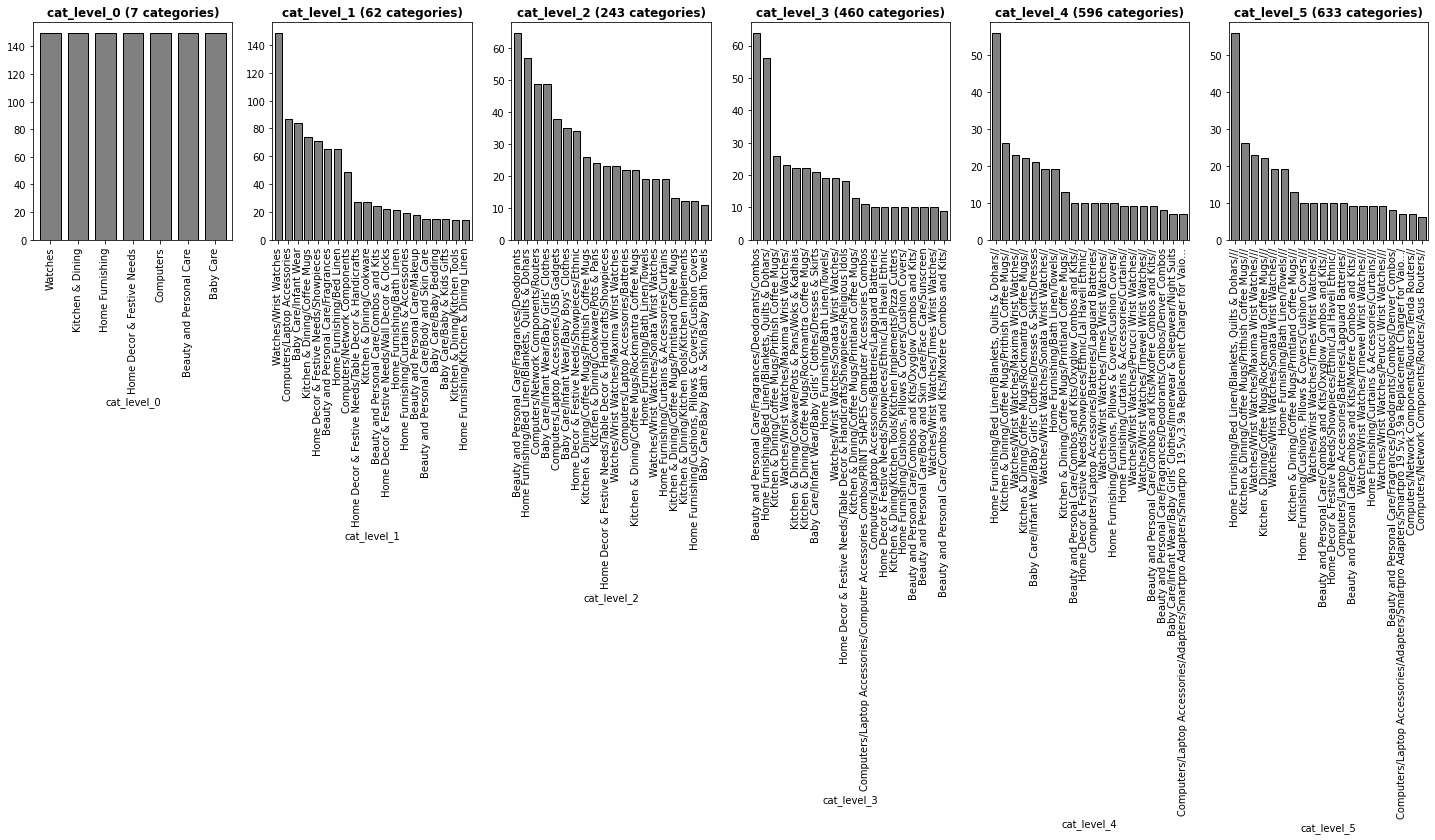

In [20]:
fig = plt.figure(figsize=(25,4))
for i, col in enumerate(df_cat_level.columns,1):
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:20].plot.bar(width=0.75, color='grey', ec='k', ax=ax)
    ax.set_title(col+f' ({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [21]:
df_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [22]:
df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                        'Baby Care': 'Baby', 
                                        'Watches': 'Watches',
                                        'Home Decor & Festive Needs': 'Decor',
                                        'Kitchen & Dining': 'Kitchen',
                                        'Beauty and Personal Care': 'Beauty',
                                        'Computers': 'Computers'})

### 1.2 Products descriptions

In [23]:
# extracting only useful data
df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

In [24]:
df_desc_cat.head()

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."


In [25]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc_cat['description'].values)
print("total nb of words in the whole corpus: ", len(corpus.split()))

total nb of words in the whole corpus:  80013


In [26]:
df_desc_cat

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n Price: Rs...
fd6cbcc22efb6b761bd564c28928483c,Baby,Wallmantra Large Vinyl Sticker Sticker,"Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n Price: Rs. 1,896\..."
5912e037d12774bb73a2048f35a00009,Baby,Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker,Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberly...


## 2 Optimisation of the text preprocessing and clustering

### FUNCTIONS

#### tokenize_clean

In [27]:
''' from a sentence, containing words (document):
- tokenizes the words if only composed of alphanumerical data,
- removes stopwords if list is given (stopwords)
- stems the words if stemmer given
NB: This pre-processing function can be used to prepare data for Word2Vec
'''
from nltk.stem.snowball import EnglishStemmer
import spacy

def tokenize_clean(document, stopwords=None, lemmatizer=None, stemmer=None):
    # 1 - tokenizing the words in each description
    tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
    li_words = tokenizer.tokenize(document)
    if stopwords is None: stopwords=[]
    # 2 - lemmatizing or stemming
    if lemmatizer is not None:
        lem_doc = lemmatizer(' '.join(li_words))
        li_words = [token.lemma_ for token in lem_doc]
    elif stemmer is not None:
        li_words = [stemmer.stem(s) for s in li_words]
    # 3 - removing stopwords
    li_words = [s for s in li_words if s not in stopwords]
    # 4 - lower case
    li_words = [s.lower() for s in li_words]
    return li_words

#### compute_doc_terms_df

In [28]:
''' Takes a pd.Series containing the texts of each description
applies a preprocessing function if given (stopwords, stemming...)
then turn the descriptions in vectors (bow of tf-idf, depending on the avlue of
 tfidf_on)
 returns document term matrix as a dataframe and the list of new excluded words.
'''

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_doc_terms_df(ser_desc, 
                         preproc_func=None,
                         preproc_func_params=None,
                         vec_params = {'min_df': 1},
                         tfidf_on=False,
                         print_opt=False):

    # ---- Apply a stemming of lemmatization prior to vectorization
    if preproc_func is not None:
        ser_desc = ser_desc.apply(lambda x: preproc_func(x,
                                                         **preproc_func_params))
        ser_desc = ser_desc.apply(lambda x: ' '.join(x))
    else:
        ser_desc = ser_desc
    
    # ---- Vectorization of each of the texts (row)
    if tfidf_on:
        # TF-IDF matrix
        vec = TfidfVectorizer(**vec_params)
    else:
        # BOW matrix (count)
        vec = CountVectorizer(**vec_params)

    doc_term = vec.fit_transform(ser_desc)
    if print_opt:
        print( "Created %d X %d doc_term matrix" % (doc_term.shape[0],
                                                    doc_term.shape[1]))

    # ---- Vocabulary of the document_term matrix
    doc_term_voc = vec.get_feature_names()
    if print_opt:
        print("Vocabulary has %d distinct terms" % len(doc_term_voc))

    # ---- Get the list of the new stop-words
    new_sw = vec.stop_words_
    if print_opt:
        print("Old stop-words list has %d entries" % len(sw) )
        print("New stop-words list has %d entries" % len(new_sw))

    doc_term_df = pd.DataFrame(doc_term.todense(),
                index=ser_desc.index, # each item
                columns=doc_term_voc) # each word

    # document term matrix as a dataframe and the list of new excluded words
    return doc_term_df, new_sw


#### CustNLPTransformer

In [29]:

''' Builds a customizable NLP column_transformer which parameters
can be optimized in a GridSearchClust
'''
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


class CustNLPTransformer(BaseEstimator):

    def __init__(self, stopwords=None, stemmer=None, lemmatizer=None,
                 min_df=0, max_df=10000, max_features=10000, tfidf_on=False,
                 ngram_range=(1,1), binary=False):
        self.stopwords = stopwords
        self.lemmatizer = lemmatizer
        self.stemmer = stemmer
        self.min_df = min_df
        self.max_df = max_df
        self.max_features = max_features
        self.tfidf_on = tfidf_on
        self.ngram_range = ngram_range
        self.binary = binary
        self.preproc_func_params={'stopwords': self.stopwords,
                                  'lemmatizer': self.lemmatizer,
                                  'stemmer': self.stemmer}
        self.vec_params = {'min_df': self.min_df,
                           'max_df': self.max_df,
                           'max_features': self.max_features,
                           'ngram_range': self.ngram_range,
                           'binary': self.binary}

    def __tokenize_clean(self, document, stopwords, lemmatizer, stemmer):
        # 1 - tokenizing the words in each description
        tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
        li_words = tokenizer.tokenize(document)
        if stopwords is None: stopwords=[]
        # 2 - lemmatizing or stemming
        if lemmatizer is not None:
            lem_doc = lemmatizer(' '.join(li_words))
            li_words = [token.lemma_ for token in lem_doc]
        elif stemmer is not None:
            li_words = [stemmer.stem(s) for s in li_words]
        # 3 - removing stopwords
        li_words = [s for s in li_words if s not in stopwords]
        # 4 - lower case
        li_words = [s.lower() for s in li_words]
        return li_words

    # "private" method to be used to apply transformation and get a df
    def __compute_doc_terms_df(self, ser_desc, preproc_func,
                             preproc_func_params, vec_params, tfidf_on):
        # ---- Apply a stemming or lemmatization prior to vectorization
        if preproc_func is not None:
            ser_desc = ser_desc.apply(lambda x: \
                                      preproc_func(x, **preproc_func_params))
            ser_desc = ser_desc.apply(lambda x: ' '.join(x))
        else:
            ser_desc = ser_desc
        # ---- Vectorization of each of the texts (row)
        if tfidf_on:
            # TF-IDF matrix
            vec = TfidfVectorizer(**vec_params)
        else:
            # BOW matrix (count)
            vec = CountVectorizer(**vec_params)
        doc_term = vec.fit_transform(ser_desc)
        # ---- Vocabulary of the document_term matrix
        doc_term_voc = vec.get_feature_names()
        # ---- Get the list of the new stop-words
        new_sw = vec.stop_words_
        doc_term_df = pd.DataFrame(doc_term.todense(),
                                   index=ser_desc.index, # each item
                                   columns=doc_term_voc) # each word
        # document term matrix as a dataframe and the list of new excluded words
        return doc_term_df

    def fit(self, X, y=None):
        # nothing to fit
        return self

    def transform(self, X, y=None):  # to get a dataframe
        df_trans = \
            self.__compute_doc_terms_df(
                ser_desc=X,
                preproc_func=self.__tokenize_clean,
                preproc_func_params=self.preproc_func_params,
                vec_params=self.vec_params,
                tfidf_on=self.tfidf_on
                                   )
        return df_trans

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

#### GridSearchClust

In [30]:
'''
Class to optimize clustering score.
Instantiate with a clusterer (estimator), a grid parameter (param_grid)
and a scoring function or a dict of scores (scoring) to be translated
in actual scores (see the compute_score)
'''

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score

class GridSearchClust(BaseEstimator, TransformerMixin):

    def __init__(self, estimator, param_grid_estim, param_grid_preproc=None,
                 scoring=None, scoring_true_lab=None, refit='silh',
                 greater_is_better=True):

        # Get the parameters
        self.estimator = estimator
        self.param_grid_estim = param_grid_estim
        self.param_grid_preproc = param_grid_preproc
        self.scoring = scoring
        self.scoring_true_lab = scoring_true_lab
        self.refit = refit
        self.greater_is_better = greater_is_better

    def __compute_score(self, X, clust_lab, n_score):

        dict_scores = {
            # Scores related to the clusters labels found by our estimator
               'silh': silhouette_score(X, clust_lab),
               'cal-har': calinski_harabasz_score(X, clust_lab),
               'dav_bould': davies_bouldin_score(X, clust_lab),
            # Scores comparing true labels and clusters found by our estimator
               'ami': adjusted_mutual_info_score(self.scoring_true_lab, clust_lab),
               'ari': adjusted_rand_score(self.scoring_true_lab, clust_lab),
               'homog': homogeneity_score(self.scoring_true_lab, clust_lab),
               'complet': completeness_score(self.scoring_true_lab, clust_lab)
               }
        return dict_scores[n_score]


    def fit(self, X, verbose=False):

        # Initialize the dict of results
        self.results_ = {"scores": {},
                         "params": [],
                         "estimators": [],
                        #  "fit_times": [],
                         "refit_score": []}

        # Iterate upon all combinations of parameters
        estim_score = defaultdict(list)
        for param in ParameterGrid(self.param_grid_estim):

            # Change the parameters of the estimator
            self.estimator = self.estimator.set_params(**param)

            # Fit the model
            self.estimator.fit(X)

            # If the estimator is a pipe, compute the first steps separately
            if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                pipe_wo_last_estim = Pipeline(self.estimator.steps[0:-1])
                X_trans = pipe_wo_last_estim.fit_transform(X)

            # Compute the labels
            labels = self.estimator.predict(X)

            # # Measure training time while fitting the model on the data
            # time_train = %timeit -n1 -r1 -o -q self.estimator.fit(X)
            # time_train = time_train.average

            # Compute the refit score
            try:
                if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                    refit_score = self.__compute_score(X_trans, labels, self.refit)
                else:
                    refit_score = self.__compute_score(X, labels, self.refit)
            except:
                print('ERREUR calcul refit_score: is scoring_true_lab correctly set ?')
                refit_score = np.nan
            
            # Other scores (scoring)
            if not self.scoring:  # if scoring parameter is/are not defined
                estim_score['score'] = {'default_score': self.estimator.score(X_trans, labels)} # default score
            else:  # If scoring parameter is/are defined
                if type(self.scoring) != list:
                    self.scoring = [self.scoring]
                else:
                    # looping over each score in the scoring list
                    for n_sco in self.scoring:
                        try:
                            if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                                estim_score[n_sco] = estim_score[n_sco] + \
                                    [self.__compute_score(X_trans, labels, n_sco)]
                            else:
                                estim_score[n_sco] = estim_score[n_sco] + \
                                    [self.__compute_score(X, labels, n_sco)]
                        except:
                            estim_score[n_sco] = estim_score[n_sco] + [np.nan]
                            print("ERROR: scores computation doesn't work")
            if verbose: print(estim_score)

            # saving results, parameters and models in a dict
            self.results_["refit_score"].append(refit_score)  # refit score
            self.results_["params"].append(param)  # parameters
            self.results_["estimators"].append(self.estimator)  # trained models
            # self.results_["fit_times"].append(time_train)  # training time

        self.results_["scores"] = dict(estim_score)  # dict of lists of scores
        self.results_["refit_score"] = np.array(self.results_["refit_score"])
  
        # Selecting best model based on the refit_score
        # -----------------------------------
        # initialisation
        best_estim_index, best_score = None, None  
        # iterating over scores
        for index, score in enumerate(self.results_["refit_score"]):

            # initialisation
            if not best_score:
                best_score = score
                best_estim_index = index

            # if score is better than current best_score
            cond = score > best_score if self.greater_is_better\
                                                 else score < best_score
            if cond:
                    # update the current best_score and current best_estim_index
                    best_score = score
                    best_estim_index = index
        
        # Update attributes of the instance
        self.best_score_ = self.results_["refit_score"][best_estim_index]
        self.best_params_ = self.results_["params"][best_estim_index]
        self.best_estimator_ = self.results_["estimators"][best_estim_index]
        self.best_index_ = best_estim_index
        # self.refit_time_ = self.results_["fit_times"][best_estim_index]

        # refit the best model
        self.best_estimator_.fit(X)
        
        return self

    def predict(self, X):

        # use the .predict method of the estimator on the best model
        return self.best_estim.predict(X)

#### filters_gsclust_results

In [31]:
''' Takes a GridSearchClust object and the name of one parameter of the
estimator (or of the pipeline) and isolate the influence of this parameter
on all the scores available in the scv (scoring)
-> returns a dictionary of the best other fixed parameters
and a dataframe of the scores depending on the chosen parameter and a 
filtered results_ dataframe that can be used
in the 'plot_scv_multi_scores' function '''

def filters_gsclust_results(gsc, param, return_df_res=False):

    gsc_res = gsc.results_
    # Generate a dataframe of all the models tested, their scores and parameters
    df_gsc = pd.DataFrame()
    for k, v in gsc_res.items():
        if type(v) == dict: # dict de listes : scores
            df_ = pd.DataFrame(v)
        elif type(v) == list:
            if type(v[0]) == dict: # liste de dicts : params
                df_ = pd.DataFrame(v)
                li_params = df_.columns
            else: # liste d'objets (estimators) ou de nombres (refit_score)
                df_ = pd.DataFrame(v, columns=[k])
        else:
            col_names = [str(k)]
            df_ = pd.DataFrame(v, columns=[k])
        df_gsc = pd.concat([df_gsc, df_], axis=1)
    df_gsc_transl = object_none_translater(df_gsc)

    # selects in the data frame the best params
    best_params = gsc.best_params_.copy() # dict of the best params
    # translation of all the non numeric values into strings (including None)
    best_params_transl = object_none_translater(best_params) 
    del best_params_transl[param] # remove the parameter that we want to plot

    # filters in the result dataframe only optimized results except for 'param'
    mask = np.full((df_gsc_transl.shape[0],), True)
    for k,v in best_params_transl.items():
        mask = mask & (df_gsc_transl[k]==v)
    df_gsc_filt = df_gsc.loc[mask]
    li_scores = gsc.get_params()['scoring']          
    df_sel_scores = df_gsc_filt[li_scores+[param]].set_index(param)
    df_res = df_gsc_transl
    if return_df_res:
        return best_params, df_sel_scores, df_gsc_filt, df_res
    else:
        return best_params, df_sel_scores, df_gsc_filt

#### plot_gsc_multiscore

In [32]:
''' Plots a selection of scores (scores) or all the scores (scores=None)
obtained during the GridSearchClust as a collection of line graphs.
The other parameters (not plotted) are the parameters of the best estimator
(found by gridsearch). They're the same for all the line plot (contrary to
the 'plot_2Dgsclust_param_opt where other params may differ for each cell).
'''

def plot_gsc_multi_scores(gsc, param, title = None, x_log=False,
                          loc='best', figsize = (12, 4), scores=None):

    best_params, df_sel_scores, _ = filters_gsclust_results(gsc,param)
    results = df_sel_scores
    
    scoring = gsc.scoring if scores is None else scores

    fig, axs = plt.subplots(1,len(scoring))
    fig.set_size_inches(figsize)

    li_colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'grey']
    if len(axs)==1 : axs = [axs]

    # Get the regular np array from the MaskedArray
        
    X_axis = np.array(results.index, dtype='float')

    for scorer, color, ax in zip(sorted(scoring), li_colors[:len(scoring)], axs):
        score = df_sel_scores[scorer].values
        
        df_ = pd.DataFrame({'param': X_axis,
                            'score': score,
                            # 'std': None,
                            }).sort_values(by='param')
        # ax.fill_between(df_['param'],
        #                 df_['score'] - df_['std'],
        #                 df_['score'] + df_['std'],
        #                 alpha=0.1, color=color)
        ax.plot(df_['param'], df_['score'], '-', marker='o', markersize=3,
            color=color, alpha=1)
        if x_log: ax.set_xscale('log')
        ax.set_title(scorer)

        y_min, y_max = ax.get_ylim()
        
        # Plot a dotted vertical line at the best score for that scorer marked by x
        best_score = results.loc[best_params[param], scorer]
        ax.plot([best_params[param], ] * 2, [y_min - abs(y_min)*0.1, best_score],
            linestyle='dotted', color=color, marker='x', markeredgewidth=3, ms=8)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel(param)
        ax.set_ylabel("Score")
        # ax.legend(loc=loc)

        # Annotate the best score for that scorer
        len_str = len("{:.2f}".format(best_score))
        if best_params[param] < np.mean(X_axis):
            x_pos = best_params[param]*(1+0.015*len_str)
        else:
            x_pos = best_params[param]*(1-0.015*len_str)
        y_pos = best_score*1+(y_max-y_min)*0.05
        ax.annotate("{:0.2f}".format(best_score), 
                    (x_pos, y_pos),
                    color = color)  
    if title is not None:
        fig.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout(rect=(0,0,1,0.92))
    else:
        plt.tight_layout()
    plt.show()

#### plot_2D_gsclust_param_opt

In [33]:
''' Takes a GridSearchClust object and plots a heatmap of a chosen score (score)
against 2 chosen parameters.
NB: the score displayed for each cell is the one for the best other parameters.
'''

def plot_2D_gsclust_param_opt(gsc, params=None, score=None,
                           title=None, shorten_label=7, ax=None):

    ax = plt.subplot(1,1,1) if ax is None else ax

    score = 'refit_score' if score is None else score

    params_gsc = params

    _, _, _, df_res = filters_gsclust_results(gsc, params_gsc[0],
                                              return_df_res=True)
    max_scores = df_res.groupby(params_gsc).agg(lambda x: max(x))[score]
    sns.heatmap(max_scores.unstack(), annot=True, fmt='.4g', ax=ax)

    if shorten_label != False:
        thr = int(shorten_label)
        lab_x = [item.get_text() for item in ax.get_xticklabels()]
        short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
        ax.axes.set_xticklabels(short_lab_x)
        lab_y = [item.get_text() for item in ax.get_yticklabels()]
        short_lab_y = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_y]
        ax.axes.set_yticklabels(short_lab_y)

    title = score if title is None else title
    ax.set_title(title)

#### TopicsModeler

In [34]:
''' Builds a topics modeler which parameters (model, number of topics)
can be optimized in a GridSearchClust.
.transform: returns the DOCUMENTS/TOPICS matrix
.predict: returns the list of the most probable topic for each document
NB: takes a dataframe as X.
'''
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

class TopicsModeler(BaseEstimator):


    def __init__(self, n_model='nmf', n_components=7, random_state=None):#, model_params):

        self.n_model = n_model
        self.n_components = n_components
        self.random_state = random_state
        # self.model_params = model_param

        # Model name -> object
        self.dict_models = {'lsa': TruncatedSVD(),
                            'nmf': NMF(init="nndsvd"),
                            'lda': LDA()}

        # Instantiate the model
        try:
            self.model = self.dict_models[self.n_model]#.set_params(*self.model_params)
        except:
            print("ERROR: unknown topics modeliser. \n\
Please, choose between 'nmf', 'lda' and 'lsa'")

    def fit(self, X, y=None):

        # Re-Instantiate the model
        try:
            self.model = self.dict_models[self.n_model]#.set_params(*self.model_params)
        except:
            print("ERROR: unknown topics modeliser. \n\
Please, choose between 'nmf', 'lda' and 'lsa'")

        # Set the parameters
        self.model.set_params(n_components = self.n_components,
                              random_state = self.random_state)

        # Fit the model
        self.model.fit(X)

        return self

    def __compute_DOC_TOP_matrix(self, X, y=None): # DOCUMENTS/TOPICS Matrix
    # actualization of n_components
        self.n_components = self.model.transform(X.values).shape[1]
        self.W = pd.DataFrame(self.model.transform(X.values),
                              index=X.index, # documents
                              columns=['topic_'+str(i)\
                                       for i in range(1,self.n_components+1)]) # topics

    def __compute_TOP_WORDS_matrix(self, X, y=None): # TOPICS/WORDS Matrix

        self.H = pd.DataFrame(self.model.components_, 
                              index=['topic_'+str(i)\
                                     for i in range(1,self.n_components+1)], # topics
                              columns=X.columns) # words

    def transform(self, X, y=None):  # to get the df of the DOC/TOPICS matrix

        self.__compute_DOC_TOP_matrix(X)
        self.__compute_TOP_WORDS_matrix(X)

        # Converting topics scores to best cluster label (higher val column)
        ser_res = self.W.idxmax(1)

        return self.W

    def predict(self, X, y=None):  # to get a ser of the best label

        self.__compute_DOC_TOP_matrix(X)
        self.__compute_TOP_WORDS_matrix(X)

        # Converting topics scores to best cluster label (higher val column)
        ser_res = self.W.idxmax(1)

        return ser_res

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X, y)

#### --- others ---

In [35]:
from sklearn.cluster import KMeans

def clustering_doc_matrix(doc_matrix_df, name, n_clusters=7):
    # Creating the Kmeans model
    km = KMeans(n_clusters = n_clusters)
    # Fitting the Kmeans model
    km.fit(doc_matrix_df)
    ser = pd.Series(km.labels_,
                    index = doc_matrix_df.index,
                    name = name)
    return ser

In [36]:
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD

def topicsmodeler_doc_matrix(doc_matrix_df, n_model, name, n_components=7):

    dict_models = {'lsa': TruncatedSVD(),
                   'nmf': NMF(init="nndsvd"),
                   'lda': LDA()}
    model = dict_models[n_model]

    # Instantiation the topic modeler
    model.set_params(n_components = n_components)

    # Fitting the the topic modeler
    model.fit(doc_matrix_df)

    # DOCUMENTS/TOPICS Matrix
    W = pd.DataFrame(model.fit_transform(doc_matrix_df.values),
                     index=doc_matrix_df.index, # documents
                     columns=['topic_'+str(i)\
                              for i in range(1,n_components+1)]) # topics

    # TOPICS/WORDS Matrix
    H = pd.DataFrame(model.components_,
                     index=['topic_'+str(i)\
                            for i in range(1,n_components+1)], # topics
                     columns=doc_matrix_df.columns) # words

    # Converting topics scores to best cluster label (higher val column)
    ser_res = pd.Series(W.idxmax(1),
                        index = W.index,
                        name = name)

    return ser_res

In [37]:
''' Transformer that translates all the non numeric values into strings
(including None) in a dict or a dataframe (column wise)
'''
import numbers
# si contient des None, alors convertir tous les objects en string

def object_none_translater(dict_or_df):
    if type(dict_or_df) == dict:
        # Change any non numeric value to string
        dict_or_df_transl = {k: v if isinstance(v, numbers.Number) else str(v)\
                             for k,v in dict_or_df.items()}
    elif type(dict_or_df) == pd.core.frame.DataFrame:
        # Change None to str (so the type of any None-containing col becomes 'object')
        dict_or_df_transl = dict_or_df.fillna('None')
        # Convert the content of all object columns to strings
        cols = dict_or_df_transl.select_dtypes('object').columns
        dict_or_df_transl[cols] = dict_or_df_transl[cols].applymap(lambda x: str(x))
    else:
        print("ERROR: you passed an object to 'object_none_translater'\
 that is neither a dict nor a pd.DataFrame")
    return dict_or_df_transl

# ''' Transformer that changes all the None values of a dict or a dataframe
# into a string 'None'
# ''' 

# def none_translater(dict_or_df):
#     if type(dict_or_df) == dict:
#         dict_or_df_transl = {k: v if v is not None else 'None' \
#                              for k,v in dict_or_df.items()}
#     elif type(dict_or_df) == pd.core.frame.DataFrame:
#         dict_or_df_transl = dict_or_df.fillna('None')
#     return dict_or_df_transl

# ''' Transformer that changes all string 'None' of a dict or a dataframe
# into a None value
# ''' 

# def inverse_none_translater(dict_or_df):
#     if type(dict_or_df) == dict:
#         dict_or_df_inv_trans = {k: v if v != 'None' else None \
#                                 for k,v in dict_or_df.items()}
#     elif type(dict_or_df) == pd.core.frame.DataFrame:
#         dict_or_df_inv_trans = dict_or_df.replace({'None': None})
#     return dict_or_df_inv_trans

## 3 One parameter optimization loop (example on max_features of CountVectorizer)

In [38]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

Descriptions pre-processing

In [39]:
# Stopwords
english_sw = nltk.corpus.stopwords.words('english')
single_let_sw = list(string.ascii_lowercase)
sw = list(set(english_sw + single_let_sw))
len(sw)

197

In [40]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

In [41]:
# Vectorization of the descriptions prior to applying NMF

doc_matrix_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None,
                                                'lemmatizer': lemmatizer},
                         vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                       'max_features':500}, # max nb of words to keep among the most used
                         tfidf_on=False)

#### KMeans Clustering

Loop optimisation of the max_feature parameter on ARI

In [42]:
# Getting the labels of clustering for each set of param (1 param)

max_features_list = [30, 70, 100, 150, 250, 500, 1000]

for max_feat in max_features_list:
    doc_matrix_df, _ = \
        compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None,
                                                'lemmatizer': lemmatizer},
                         vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                       'max_features':max_feat}, # max nb of words to keep among the most used
                         tfidf_on=False)
    # Appending the best results of the Kmeans clustering
    df_res_clust = pd.concat([df_res_clust,
                              clustering_doc_matrix(doc_matrix_df,
                                                    name='KM_'+str(max_feat))],
                             axis=1)

In [43]:
df_res_clust.sample(5)

,categories,KM_30,KM_70,KM_100,KM_150,KM_250,KM_500,KM_1000
uniq_id,,,,,,,,
62c35de4df27437d3597963fac55a8b6,Watches,0,5,3,2,2,1,1
0d3e1dc0d38be59e9927e47f152e48aa,Kitchen,6,2,6,5,4,1,1
721c1b67f86176f741d43cae1d1c7e93,Furnishing,2,6,1,0,1,5,6
de29bf3288345e23b0e25345a3a057fb,Decor,2,2,1,5,1,5,1
f2689f048b3b6f0ff863bf0cce28873d,Beauty,0,5,3,5,2,1,1


In [44]:
# Comparison of clusters labels with true categories

from sklearn.metrics import adjusted_rand_score

ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 7 others ---
ARI: mean=0.122, std=0.045, min=0.052, max=0.158 


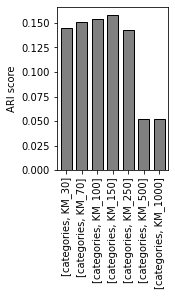

In [45]:
# Plotting the results

fig = plt.figure(figsize=(2,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Topics Modeler Clustering

Loop optimisation of the max_feature parameter on ARI

In [46]:
# Getting the labels of clustering for each set of param (1 param)

max_features_list = [30, 70, 100, 150, 250, 500, 1000]

for max_feat in max_features_list:
    doc_matrix_df, _ = \
        compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None,
                                                'lemmatizer': lemmatizer},
                         vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                       'max_features':max_feat}, # max nb of words to keep among the most used
                         tfidf_on=False)
    # Appending the best results of the Topics Modeler clustering
    df_res_clust = pd.concat([df_res_clust,
                              topicsmodeler_doc_matrix(doc_matrix_df,
                                                         n_model='nmf',
                                                         name='TM_'+str(max_feat),
                                                         n_components=7)],
                             axis=1)
                            #   clustering_doc_matrix(doc_matrix_df,
                            #                         str(max_feat))], axis=1)

In [47]:
df_res_clust.sample(5)

,categories,KM_30,KM_70,KM_100,KM_150,KM_250,KM_500,KM_1000,TM_30,TM_70,TM_100,TM_150,TM_250,TM_500,TM_1000
uniq_id,,,,,,,,,,,,,,,
63f2d92a3f5fc6cfc11e7f99d5798eac,Decor,3,6,0,0,1,0,6,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3
14bc693d9b86c58696e5917045e9d4de,Furnishing,0,5,3,5,2,1,1,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2
ce2f67c3365846170cb709784d87e45b,Kitchen,6,2,6,5,4,1,1,topic_6,topic_7,topic_7,topic_7,topic_2,topic_2,topic_2
97fba8a02361aa56eaa9fa51bc1d7661,Watches,0,5,3,2,2,1,1,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2
f2658bad8c2b7d5b08984c6ac34267f7,Furnishing,3,6,0,0,1,5,6,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3


In [48]:
# Comparison of clusters labels with true categories

from sklearn.metrics import adjusted_rand_score

ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 14 others ---
ARI: mean=0.125, std=0.046, min=0.052, max=0.174 


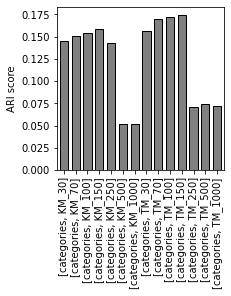

In [49]:
# Plotting the results

fig = plt.figure(figsize=(3,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

## 4 GridSearch optimization of the text preprocessing parameters

### 4.0 GridSearch try (KMeans components optimization) on BOW

In [50]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
completeness_score, homogeneity_score

# Definition of the search space for hyperparameters
param_grid = {"n_components": [4,5,6,7,8],
              "n_model": ['lda', 'nmf', 'lsa']}

# Instanciation of the GridSearch object
gsc = GridSearchClust(estimator=TopicsModeler(random_state=14), # KMeans()
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True, # for the refit_score
                      )

# Computing the results of the grid search
gsc.fit(doc_matrix_df, verbose=False);

# Displays best parameters
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
scores_df = pd.DataFrame(gsc_res['scores'],
                         index = pd.DataFrame(gsc_res['params']))#.iloc[:,0])
scores_df

Best hyperparameters: {'n_components': 7, 'n_model': 'lda'}
Best refit score: 0.21076823996883529


,silh,cal-har,dav_bould,ami,ari,homog,complet
"(4, lda)",0.04,72.17,2.78,0.24,0.13,0.20,0.32
"(4, nmf)",0.21,91.00,2.73,0.13,0.06,0.10,0.18
"(4, lsa)",0.18,77.93,2.57,0.10,0.05,0.08,0.15
"(5, lda)",0.04,62.37,3.16,0.31,0.19,0.27,0.37
"(5, nmf)",0.22,78.01,2.64,0.13,0.06,0.11,0.18
"(5, lsa)",0.19,67.36,2.32,0.11,0.05,0.09,0.16
"(6, lda)",0.05,51.50,3.48,0.33,0.21,0.31,0.38
"(6, nmf)",0.21,67.72,2.89,0.19,0.07,0.17,0.25
"(6, lsa)",0.21,61.89,2.32,0.17,0.07,0.15,0.23
"(7, lda)",0.06,49.14,3.62,0.35,0.21,0.34,0.39


### 4.1 GridSearch optimization (preproc -> clustering)

#### Grid search to optimize preprocessing and PCA parameters (KMeans)

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Dimensionality reduction (PCA)
- KMeans clustering (7 categories)

In [51]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from nltk.stem.snowball import EnglishStemmer
import spacy

# Define the stemmer or the lemmatizer
stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('pca', PCA()), # PCA feature reduction
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {'custtrans__stopwords': [sw], # [sw, None],
              'custtrans__stemmer': [None],#[stemmer, None],
              'custtrans__lemmatizer': [lemmatizer], #, None],
              'custtrans__min_df': (np.linspace(0,30,10)).astype('int'),
              'custtrans__max_df': [500, 1000, 1500],
              'custtrans__max_features': [5000],
              'custtrans__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3), (1,2,3)],
              'custtrans__binary': [True, False],
              'custtrans__tfidf_on': [True, False],
              'pca__n_components': [6,10,15,20,30,40,50,60,70],#[15,20,25,30,35,40],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ami',
                      greater_is_better=True) # for the refit_score


In [52]:
# ##### Perform the grid search on the whole descriptions
# gsc_desc = copy.deepcopy(gsc)
# gsc_desc.fit(df_desc_cat['description'], verbose=False);

# ##### Perform the grid search on the product names
# gsc_pname = copy.deepcopy(gsc)
# gsc_pname.fit(df_desc_cat['product_name'], verbose=False);

# ### Pickling the results
# import dill as pickle
# with open('gsc_prep_pca_km_WD.pkl', 'wb') as file:
#     pickle.dump(gsc_desc, file)
# with open('gsc_prep_pca_km_PN.pkl', 'wb') as file:
#     pickle.dump(gsc_pname, file)

In [54]:
### Loading the results
import dill as pickle
with open('gsc_prep_pca_km_WD.pkl', 'rb') as file:
    gsc_desc = pickle.load(file)
with open('gsc_prep_pca_km_PN.pkl', 'rb') as file:
    gsc_pname = pickle.load(file)

# Display results (whole descriptions)
print("-----Whole descriptions")
print("Best hyperparameters:", gsc_desc.best_params_)
print("Best refit score:", gsc_desc.best_score_)
gsc_desc_res = gsc_desc.results_
scores_desc_df = pd.DataFrame(gsc_desc_res['scores'],
                              index = pd.DataFrame(gsc_desc_res['params']).iloc[:,0])

# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc_pname.best_params_)
print("Best refit score:", gsc_pname.best_score_)
gsc_pname_res = gsc_pname.results_
scores_pname_df = pd.DataFrame(gsc_pname_res['scores'],
                         index = pd.DataFrame(gsc_pname_res['params']).iloc[:,0])


-----Whole descriptions
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__lemmatizer': <spacy.lang.en.English object at 0x7eff4f64ceb8>, 'custtrans__max_df': 1500, 'custtrans__max_features': 5000, 'custtrans__min_df': 23, 'custtrans__ngram_range': (3, 3), 'custtrans__stemmer': None, 'custtrans__stopwords': ['to', 'wasn', 'couldn', 'after', 'just', 'same', 'nor', "isn't", 'so', 'myself', 'how', 'if', 'who', 'from', 'were', 'o', "needn't", 'until', 'z', 'had', 'up', 'ain', 'x', 'or', 'below', "wasn't", 'your', 'above', 'having', 'r', 'mustn', 'when', 'don', 'weren', 'yourself', 'such', 'has', 'q', "you'd", 'is', 'of', 'h', 'most', 'with', 'on', 'because', "hasn't", "didn't", "don't", 'i', "shan't", 'isn', 'mightn', 'over', "aren't", 'wouldn', 'an', "mustn't", 'no', 'doing', 'shouldn', 'doesn', 'll', 'do', 'each', 'their', "couldn't", 'theirs', 'here', 'in', 're', 'yours', 'hers', 'aren', 'me', 'about', "won't", 'm', 'and', 'why', 'y', 'into', 'd',

In [55]:
scores_pname_df

,silh,cal-har,dav_bould,ami,ari,homog,complet
clusterer__n_clusters,,,,,,,
7,0.62,941.00,0.49,0.54,0.27,0.49,0.61
7,0.47,313.65,0.91,0.51,0.21,0.46,0.58
7,0.36,189.15,1.26,0.59,0.32,0.54,0.67
7,0.29,142.34,1.20,0.56,0.28,0.51,0.63
7,0.22,93.06,1.53,0.47,0.17,0.40,0.58
...,...,...,...,...,...,...,...
7,0.33,147.94,1.35,0.55,0.28,0.51,0.62
7,0.28,120.80,1.37,0.52,0.27,0.47,0.60
7,0.21,93.72,1.77,0.51,0.21,0.46,0.59


In [ ]:
speak("youpi cé fini")

Plotting the results of the clustering optimization

In [56]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc_pname, 'pca__n_components',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet
pca__n_components,,,,,,,
6,0.62,940.95,0.49,0.54,0.27,0.49,0.61
10,0.48,336.71,0.75,0.54,0.26,0.48,0.61
15,0.36,190.34,0.97,0.53,0.25,0.48,0.61
20,0.28,137.94,1.45,0.62,0.35,0.57,0.68
30,0.14,92.21,1.53,0.50,0.19,0.43,0.62
40,0.12,75.38,1.63,0.56,0.26,0.49,0.66
50,0.15,63.70,1.73,0.49,0.16,0.41,0.62
60,0.15,56.76,1.91,0.49,0.18,0.41,0.64
70,0.07,51.48,2.17,0.54,0.25,0.46,0.67


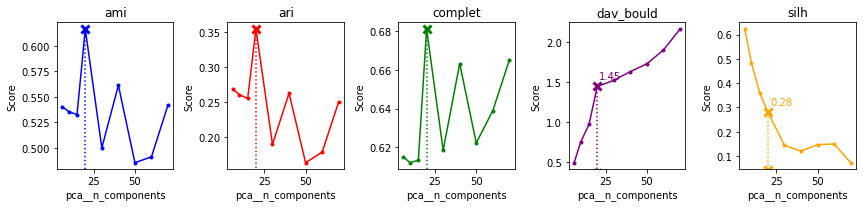

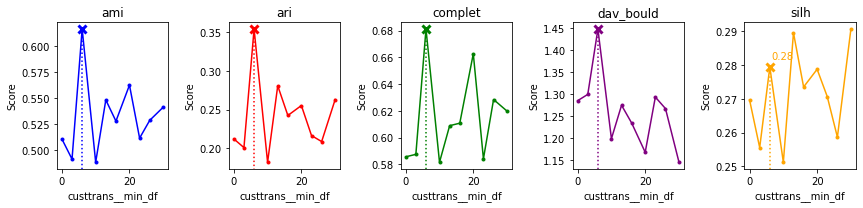

In [57]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc_pname, param='pca__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc_pname, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

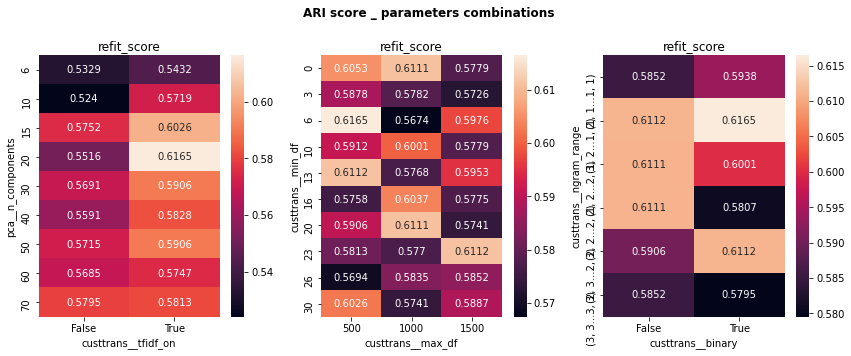

In [58]:
# Effect of 2 parameters on clustering scores

params1 = ['pca__n_components', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'custtrans__max_df']
params3 = ['custtrans__ngram_range', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc_pname, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc_pname, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc_pname, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

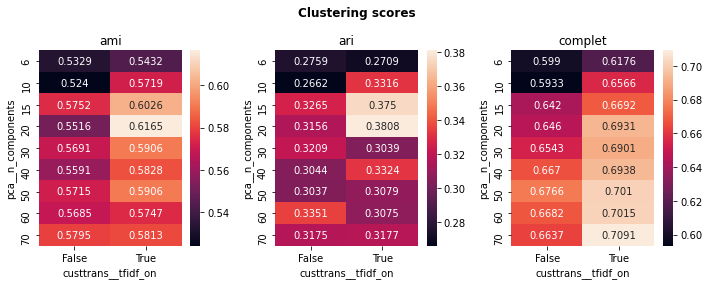

In [59]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(10,4))
params = ['pca__n_components', 'custtrans__tfidf_on']

scores = ['ami', 'ari', 'complet'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc_pname, params=params,
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

#### Grid search to optimize preprocessing and PCA parameters (Topics Modeling)

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Dimensionality reduction (PCA)
- KMeans clustering (7 categories)

In [72]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from nltk.stem.snowball import EnglishStemmer
import spacy

# Define the stemmer or the lemmatizer
stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])


# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('stand', CustTransformer(strat_quant='stand')), # Standardizer
                 ('pca', PCA()), # PCA feature reduction
                 ('clusterer', TopicsModeler(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {'custtrans__stopwords': [sw], # [sw, None],
              'custtrans__stemmer': [None],#[stemmer, None],
              'custtrans__lemmatizer': [lemmatizer], #, None],
              'custtrans__min_df': (np.linspace(0,30,10)).astype('int'),
              'custtrans__max_df': [None],
              'custtrans__max_features': [5000],
              'custtrans__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3), (1,2,3)],
              'custtrans__binary': [True, False],
              'custtrans__tfidf_on': [True, False],
              'pca__n_components': [10,15,20,30,40,50,60,70],#[15,20,25,30,35,40],
              'clusterer__n_model': ['lsa'],# 'nmf', 'lda',  
              'clusterer__n_components': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ami',
                      greater_is_better=True) # for the refit_score


In [73]:
##### Perform the grid search on the whole descriptions
gsc_desc = copy.deepcopy(gsc)
gsc_desc.fit(df_desc_cat['description'], verbose=False);

##### Perform the grid search on the product names
gsc_pname = copy.deepcopy(gsc)
gsc_pname.fit(df_desc_cat['product_name'], verbose=False);

### Pickling the results
import dill as pickle
with open('gsc_prep_pca_tm_WD.pkl', 'wb') as file:
    pickle.dump(gsc_desc, file)
with open('gsc_prep_pca_tm_PN.pkl', 'wb') as file:
    pickle.dump(gsc_pname, file)

AttributeError: ignored

In [ ]:
### Loading the results
import dill as pickle
with open('gsc_prep_pca_tm_WD.pkl', 'rb') as file:
    gsc_desc = pickle.load(file)
with open('gsc_prep_pca_tm_PN.pkl', 'rb') as file:
    gsc_pname = pickle.load(file)

# Display results (whole descriptions)
print("-----Whole descriptions")
print("Best hyperparameters:", gsc_desc.best_params_)
print("Best refit score:", gsc_desc.best_score_)
gsc_desc_res = gsc_desc.results_
scores_desc_df = pd.DataFrame(gsc_desc_res['scores'],
                              index = pd.DataFrame(gsc_desc_res['params']).iloc[:,0])

# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc_pname.best_params_)
print("Best refit score:", gsc_pname.best_score_)
gsc_pname_res = gsc_pname.results_
scores_pname_df = pd.DataFrame(gsc_pname_res['scores'],
                         index = pd.DataFrame(gsc_pname_res['params']).iloc[:,0])


In [ ]:
scores_pname_df

In [ ]:
speak("youpi cé fini")

Plotting the results of the clustering optimization

In [ ]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc_pname, 'pca__n_components',
                                    return_df_res=True)
df_sel_scores

In [ ]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc_pname, param='pca__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc_pname, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

In [ ]:
# Effect of 2 parameters on clustering scores

params1 = ['pca__n_components', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'custtrans__max_df']
params3 = ['custtrans__ngram_range', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc_pname, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc_pname, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc_pname, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

In [ ]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(10,4))
params = ['pca__n_components', 'custtrans__tfidf_on']

scores = ['ami', 'ari', 'complet'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc_pname, params=params,
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

#### Reduction de dimension

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD

k=7 # number of categories

nmf = NMF(init="nndsvd",
          n_components=k)
lda = LDA(n_components=k)
lsa = TruncatedSVD(n_components=k)